# Exploratory Data Analysis

In this notebook, the complete domain data is analyzed to first filter out all rows that prove to be relevant and valuable for training. Removing rows that contain invalid or duplicate values within the text column and retrieving only English texts are the intial steps, which leaves us with around 39k rows of input data to work with.

### Pre-processing
Pre-processing tasks are also included and employed to varying degrees depending on the NLP task. The following pre-processing steps are available

- remove HTML tags
- remove accented characters
- expand contractions
- remove punctuations
- remove stop words
- transform lowercase
- lemmatize
- tokenize

### Feature Engineering
Slight feature engineering is also performed here in which certain columns are merged together due to their similarities and values transformed in a way that it is easier for certain models to understand (one-hot labeling of the categories for multi-label classification)

### Merged columns 
 * delivery + delivery_reliability = delivery
 * feedback_return = return
 * payment + pricing = monetary
 * product + product_quality = product

### Wordcloud
The wordcloud visualizaion, for instance, uses all pre-processing steps in order to only retain most of the meanigful words and to reduce these words in to theri respective base forms (lemmatization)




# Setup Libraries

In [1]:
!pip install scikit-plot >>/dev/null

In [2]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm, trange
import os
import time
import random
from bs4 import BeautifulSoup
import unicodedata
from collections import Counter
from wordcloud import WordCloud

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')
sns.set(font_scale=1.2)        

# Import Scikit-learn moduels
import scikitplot as skplt

# NLTK
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Configs
* Google Drive mounting
* Project wide constants

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Constants

* `all` = the complete unprocessed data (400k+)
* `normalized` = chosen subset of the complete data that has gone through the preprocessing pipeline
* `onehot` = Specifically for the Multi-label classification task prefered shape of the categories

In [4]:
PROJECT_PATH = '/content/drive/MyDrive/Colab/data/ma_data/'
RANDOM_SEED = 5678
RAW_DATA_PATH = '/content/drive/MyDrive/Colab/data/ma_data/feedback_all.csv'
NORMALIZED_DATA_PATH = PROJECT_PATH + 'ma_feedback_all_normalized.csv'
DATA_ONEHOT_PATH = PROJECT_PATH + 'ma_feedback_onehot_39k.csv'

### Stopwords
* Collections of words that do not contribute much for specific NLP tasks (e.g. Wordcloud below)
* `DOMAIN_STOPWORDS` and `NGRAM_STOPWORDS` Specifically helped support the unsupervised sentiment analysis task with VADER (see ma_data_sa.ipynb) since they tend to skew the results

In [5]:
DOMAIN_STOPWORDS = ['lady','sir', 'gentleman', 'madam', 'sirs', 'madams', 'dear',
                    'gentlemen', 'ladies', 'hello', 'zalando', 'team', 'zalandoteam',
                    'sincerely', 'regards', 'lg', 'mfg', 'vg', 'hi', 'hey', 'greeting']
NGRAM_STOPWORDS = ['best regards', 'yours sincerely', 'many thanks', 'good bye', 
                    'good day', 'good morning', 'good evening', 'kind regards', 
                    'thank you', 'happy easter', 'merry christmas', 'thanks in advance',
                    'friendly greeting', 'nice day']

stop_words_list = stopwords.words('english')
STOPWORDS = stop_words_list + DOMAIN_STOPWORDS

### Contractions
Contraction in this context are words that in their short form often used with an apostrophe. Expanding these contractions makes these words possible to perform pre-processing tasks on, e.g. lemmatization

In [24]:
CONTRACTION_MAP = {
  "ain't": "is not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so as",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you would",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
}

# Load Data
* Loads and displays basic information of the dataset

In [6]:
def load_data(filename, columns, text_col_id):
  print("====================Loading data====================")
  df_raw = pd.read_csv(filename)
  print('Original Data length: ', len(df_raw))

  df_filtered = df_raw[columns]
  contains_null = df_filtered.isnull().values.any()
  contains_duplicate = df_filtered[text_col_id].nunique() == df_filtered.shape[0]

  if contains_null:
    print("Dropping null values...")
    df_filtered = df_filtered.dropna(axis=1, how='all')
  
  if not contains_duplicate:
    print("Dropping duplicate text values...")
    df_filtered = df_filtered.drop_duplicates(
        subset=[text_col_id], 
        keep='first')

  print('Unique filtered data length: ', len(df_filtered))

  return df_filtered

In [7]:
def merge_two_columns(df, cols, new_col_id):
  new_col = []
  for _, row in df.iterrows():
    if row[cols[0]] or row[cols[1]]:
      new_col.append(True)
    else:
      new_col.append(False)

  df[new_col_id] = new_col
  return df

In [8]:
def render_label_distribution(df, labels, num_columns):
  fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 5, 7))
  
  counter = 0
  for idx in range(0, len(labels)):

    if (counter == num_columns):
      fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 5, 7))
      counter = 0
    
    graph = sns.countplot(x=labels[idx], 
                  data=df[[labels[idx]]], 
                  ax=ax[counter])
    graph.set(xlabel=None)
    graph.set(ylabel=None)
    graph.set(title=labels[idx])

    counter += 1

In [9]:
columns_filtered = ['sentiment',
                    'delivery',
                    'feedback_return',
                    'payment',
                    'pricing',
                    'product',
                    'feedback_text_en']

df_filtered = load_data(RAW_DATA_PATH, columns_filtered, 'feedback_text_en')

====================Loading data====================


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Original Data length:  436805
Dropping null values...
Dropping duplicate text values...
Unique filtered data length:  38972


In [12]:
df_filtered.sample(5)

,sentiment,delivery,feedback_return,payment,pricing,product,feedback_text_en
15592,NEGATIVE,True,False,True,False,False,"Ladies and gentlemen, with reference to your t..."
54732,POSITIVE,False,False,False,False,False,Just keep it up ...
27248,NEGATIVE,False,False,False,False,True,"Dear Sir / Madam, In november xxxx I ordered t..."
32424,POSITIVE,True,False,False,False,True,"Everything went super. Fast shipping, goods as..."
1494,NEGATIVE,False,False,False,False,True,"Hello, I&#39;ve been washing Nike&#39;s sports..."


### Narrow down columns
* Initial inspection of the data revealed that many columns do not contain enough useful information
* the following columns (excluding sentiment column) have been chosen as categories for the Multi label classification task since they should have enough data
* `payment` and `pricing` have been combined in to `monetary` since their texts are similar
* `one_hot_labels` as appropriate numerical shape for the MLC task (see ma_mlc_train.ipynb)

In [10]:
df_merged = df_filtered.copy()
df_merged = merge_two_columns(df_merged, ['payment', 'pricing'], 'monetary')

In [11]:
label_cols = ['delivery', 'feedback_return', 'product', 'monetary']
df_merged['one_hot_labels'] = list(np.multiply(df_merged[label_cols].values, 1))

In [12]:
df_merged.drop(columns=['payment', 'pricing'], inplace=True)

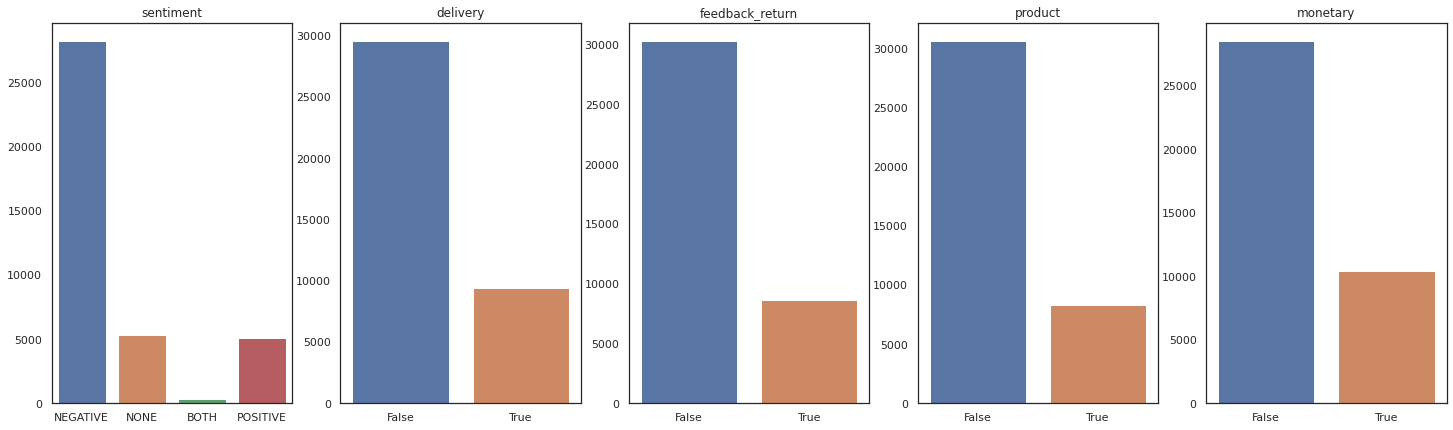

In [17]:
cols = ['sentiment'] + label_cols
render_label_distribution(df_merged, cols, 5)

In [15]:
df_merged["delivery"].value_counts(normalize=True)

False    0.758596
True     0.241404
Name: delivery, dtype: float64

In [16]:
df_merged["feedback_return"].value_counts(normalize=True)

False    0.777481
True     0.222519
Name: feedback_return, dtype: float64

In [17]:
df_merged["product"].value_counts(normalize=True)

False    0.785821
True     0.214179
Name: product, dtype: float64

In [18]:
df_merged["monetary"].value_counts(normalize=True)

False    0.732192
True     0.267808
Name: monetary, dtype: float64

In [ ]:
# re-order the columns
df_onehot = df_merged[["feedback_text_en", "sentiment", "delivery", "feedback_return", "product", "monetary", "one_hot_labels"]]
df_onehot[["sentiment", "delivery", "feedback_return", "product", "monetary", "one_hot_labels"]].head()

,sentiment,delivery,feedback_return,product,monetary,one_hot_labels
0,NEGATIVE,False,False,True,False,"[0, 0, 1, 0]"
1,NEGATIVE,False,False,True,False,"[0, 0, 1, 0]"
2,NEGATIVE,False,False,True,False,"[0, 0, 1, 0]"
3,NEGATIVE,False,False,False,True,"[0, 0, 0, 1]"
4,NEGATIVE,False,True,False,False,"[0, 1, 0, 0]"


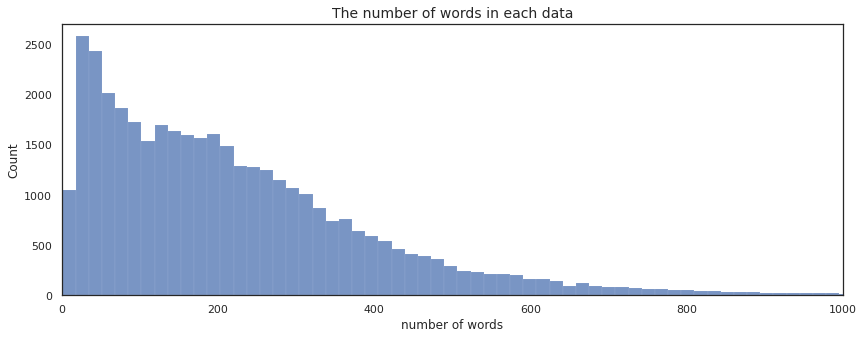

In [ ]:
fig, ax = plt.subplots(1,figsize=(14,5))

sns.histplot([len(x) for x in df_onehot['feedback_text_en'].astype(str).tolist()], ax=ax, bins=1000)
ax.set_title('The number of words in each data', fontsize=14)
ax.set_xlim(0,1000)
ax.set_xlabel('number of words')
plt.show()

In [ ]:
def get_avg_word_count(texts):
    word_counts = [len(text) for text in texts]
    avg = sum(word_counts)/len(word_counts)
    print(f"The average word count is {round(avg)}")

In [ ]:
texts = df_onehot['feedback_text_en'].astype(str).tolist()
get_avg_word_count(texts)

The average word count is 240


In [ ]:
df_onehot.to_csv(DATA_ONEHOT_PATH)

In [ ]:
# CHECKPOINT
cols = ["feedback_text_en",	"sentiment",	"delivery",	"feedback_return", "product", "monetary", "one_hot_labels"]

df_checkpoint = load_data(DATA_ONEHOT_PATH, cols, "feedback_text_en")

====================Loading data====================
Original Data length:  38972
Dropping null values...
Dropping duplicate text values...
Unique filtered data length:  38972


In [ ]:
df_checkpoint.sample(5)

,feedback_text_en,sentiment,delivery,feedback_return,product,monetary,one_hot_labels
23751,Very light and a pleasant to wear.,NEGATIVE,False,False,True,False,[0 0 1 0]
1647,The pants have been washed (30 degrees easy to...,NEGATIVE,False,False,True,False,[0 0 1 0]
36728,"Dear ladies and gentlemen, the order has alrea...",NEGATIVE,False,False,False,True,[0 0 0 1]
24828,Dear Sir / Madam May I ask you to cancel the o...,NEGATIVE,False,False,False,False,[0 0 0 0]
35071,Check your goods issue better.,NONE,False,False,False,False,[0 0 0 0]


In [ ]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, ' ', text)

    # Remove words containing at least 3 'x'
    text = re.sub(r'(\b\w*[x,X]{3,}\w*\b)', '', text)
    text = " ".join(text.split())

    return text

def remove_ngram_stopwords(text, ngram_stopwords=NGRAM_STOPWORDS):
    texts_lower = text.lower()
    reg = re.compile('|'.join(map(re.escape, ngram_stopwords)))
    text_filtered = reg.sub("", texts_lower)
    text = " ".join(text_filtered.split())
    return text

def remove_stopwords(text, stopwords_list=STOPWORDS):
    texts_lower = text.lower()
    word_list = texts_lower.split()
    text_filtered_list = [word for word in word_list if word not in stopwords_list]
    text_filtered = ' '.join(text_filtered_list)    
    return text_filtered

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()

    def nltk_tag_to_wordnet_tag(nltk_tag):
      if nltk_tag.startswith('J'):
        return wordnet.ADJ
      elif nltk_tag.startswith('V'):
        return wordnet.VERB
      elif nltk_tag.startswith('N'):
        return wordnet.NOUN
      elif nltk_tag.startswith('R'):
        return wordnet.ADV
      else:          
        return None

    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_text = []
    for word, tag in wordnet_tagged:
      if tag is None:
        lemmatized_text.append(word)
      else:        
        lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    
    return " ".join(lemmatized_text)

def normalize_text_list(texts):
    normalized_text = []
    for text in texts:
      text_tmp = remove_html_tags(text)
      text_tmp = remove_accented_chars(text)
      text_tmp = expand_contractions(text_tmp)
      text_tmp = remove_special_characters(text_tmp)
      text_tmp = remove_ngram_stopwords(text_tmp)
      text_tmp = remove_stopwords(text_tmp, DOMAIN_STOPWORDS)
      text_tmp = lemmatize_text(text_tmp)
      normalized_text.append(text_tmp)

    return normalized_text

In [ ]:
%%time
texts = df_checkpoint["feedback_text_en"].astype(str).to_list()
texts_normalized = normalize_text_list(texts)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.geox.com/de-DE/jr_orizont_boy_abx-xxxxxxxxxxxxxxxx.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 2min 4s, sys: 1.73 s, total: 2min 6s
Wall time: 2min 6s


In [ ]:
df_normalized = df_checkpoint[['sentiment', 'one_hot_labels', 'feedback_text_en']]
df_normalized['feedback_normalized'] = texts_normalized
df_normalized.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sentiment,one_hot_labels,feedback_text_en,feedback_normalized
33869,POSITIVE,[1 0 0 0],"very pretty dress, super fast delivery, always...",very pretty dress super fast delivery always h...
38511,NEGATIVE,[0 0 0 1],"Good day Unfortunately, today I have the 1st r...",unfortunately today i have the st reminder reg...
17843,NEGATIVE,[0 0 0 1],I have already paid and have received an email...,i have already pay and have receive an email r...
6748,NEGATIVE,[0 1 0 0],Jeans would be complained and sent back! Pleas...,jean would be complain and send back please ch...
3121,NEGATIVE,[0 0 0 1],"Hello, you can deduct the amount of my voucher...",you can deduct the amount of my voucher which ...


In [ ]:
df_normalized.to_csv(NORMALIZED_DATA_PATH)

# Visualizations

Wordcloud to visualize words 

In [ ]:
def get_corpus(texts):
    corpus = []
    for text in texts:
      tokens = text.split()
      corpus.extend(tokens)

    return corpus

In [ ]:
def render_wordcloud(corpus, stopwords=STOPWORDS):
    stopwords = set(STOPWORDS)
    text = " ".join(corpus)
    wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
sentiment_positive = df_normalized['sentiment'] == 'POSITIVE'
sentiment_negative = df_normalized['sentiment'] == 'NEGATIVE'

In [ ]:
df_positive = df_normalized[sentiment_positive]
df_negative = df_normalized[sentiment_negative]

In [ ]:
corpus_neg = get_corpus(df_negative['feedback_normalized'].to_list())
corpus_pos = get_corpus(df_positive['feedback_normalized'].to_list())

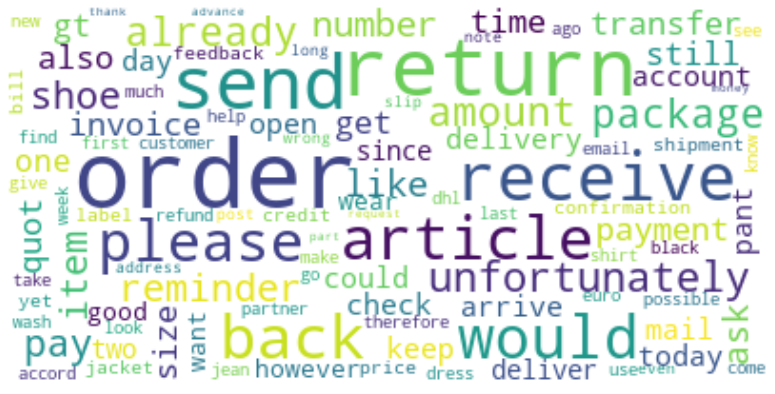

In [ ]:
render_wordcloud(corpus_neg)

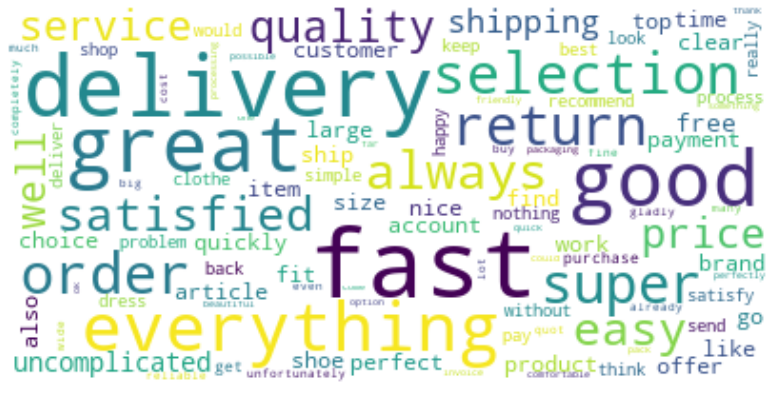

In [ ]:
render_wordcloud(corpus_pos)

In [ ]:
def render_word_freq(corpus, stopwords=STOPWORDS):
    counts = Counter(corpus)
    most = counts.most_common()[:30]
    x, y = [], []
    for word, count in most:
        if word not in stopwords:
            x.append(word)
            y.append(count)
    plt.figure(figsize=(12,10))
    sns.barplot(x=y, y=x)
    plt.show()

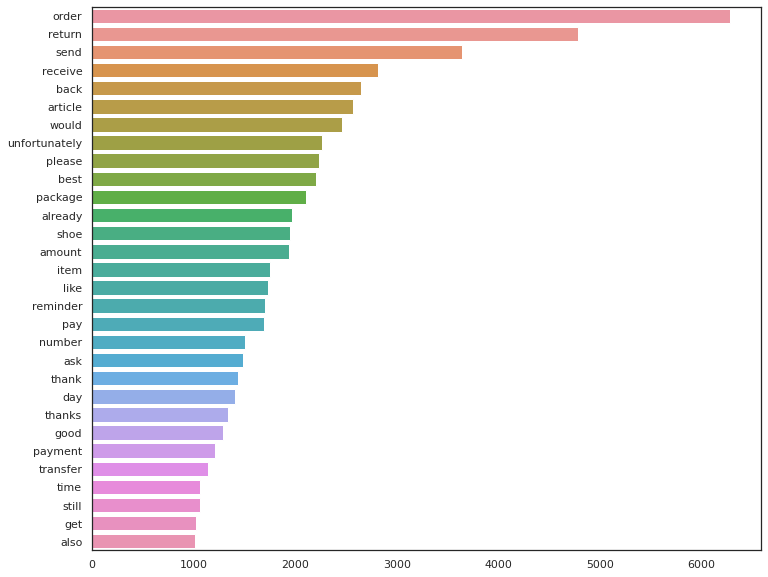

In [ ]:
render_word_freq(corpus)